In [1]:
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import os
import pandas as pd
import numpy as np

In [2]:
TRAIN_DIR =r'C:\Users\mehta\OneDrive\Desktop\Face_Emotion_Detection\archive\train'
TEST_DIR =r'C:\Users\mehta\OneDrive\Desktop\Face_Emotion_Detection\archive\test'

### Configuring GPU for more efficient training

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.10.1
Num GPUs Available:  1


In [4]:
def createDataFrame(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        label_path = os.path.join(dir, label)
        if os.path.isdir(label_path):  # Check if it's a directory
            for imagename in os.listdir(label_path):
                image_paths.append(os.path.join(label_path, imagename))
                labels.append(label)
        print(label, "completed")
    return image_paths, labels


In [5]:
train = pd.DataFrame()
train['Image'],train['Labels'] = createDataFrame(TRAIN_DIR)

angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed


In [6]:
train.shape

(28709, 2)

In [7]:
train.head()

,Image,Labels
0,C:\Users\mehta\OneDrive\Desktop\Face_Emotion_D...,angry
1,C:\Users\mehta\OneDrive\Desktop\Face_Emotion_D...,angry
2,C:\Users\mehta\OneDrive\Desktop\Face_Emotion_D...,angry
3,C:\Users\mehta\OneDrive\Desktop\Face_Emotion_D...,angry
4,C:\Users\mehta\OneDrive\Desktop\Face_Emotion_D...,angry


In [8]:
test = pd.DataFrame()
test['Image'],test['Labels'] = createDataFrame(TEST_DIR)

angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed


In [9]:
test.shape

(7178, 2)

In [10]:
test.head()

,Image,Labels
0,C:\Users\mehta\OneDrive\Desktop\Face_Emotion_D...,angry
1,C:\Users\mehta\OneDrive\Desktop\Face_Emotion_D...,angry
2,C:\Users\mehta\OneDrive\Desktop\Face_Emotion_D...,angry
3,C:\Users\mehta\OneDrive\Desktop\Face_Emotion_D...,angry
4,C:\Users\mehta\OneDrive\Desktop\Face_Emotion_D...,angry


In [11]:
from tqdm.notebook import tqdm

In [12]:
def extractFeatures(images):
    features = []
    for image in tqdm(images):
        img = load_img(image,grayscale =  True )
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features),48,48,1)
    return features
    

In [13]:
train_features = extractFeatures(train['Image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

C:\Users\mehta\anaconda3\envs\py310\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [14]:
test_features = extractFeatures(test['Image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [15]:
X_train = train_features/255.0
X_test = test_features/255.0

In [16]:
from sklearn.preprocessing import LabelEncoder

In [17]:
le = LabelEncoder()
le.fit(train['Labels'])

LabelEncoder()

In [18]:
y_train = le.transform(train['Labels'])
y_test = le.transform(test['Labels'])

In [19]:
X_train.shape

(28709, 48, 48, 1)

In [20]:
y_train.shape

(28709,)

In [21]:
y_train = to_categorical(y_train,num_classes=7)
y_test = to_categorical(y_test,num_classes=7)

In [22]:
y_train.shape

(28709, 7)

### Defining the CNN architecture

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Model definition
model = Sequential()

# 1st Convolutional layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# 2nd Convolutional layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# 3rd Convolutional layer
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Flattening and fully connected layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Output layer for 7 classes
model.add(Dense(7, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 128)       0

In [28]:
X_train.shape

(28709, 48, 48, 1)

### Training the model

In [33]:
#model.fit(X_train,y_train,batch_size=128,epochs=10,validation_data=(X_test,y_test))
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Fit model with the generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=100,
    validation_data=(X_test, y_test)
)


Epoch 1/100
449/449 [==============================] - 11s 25ms/step - loss: 1.2056 - accuracy: 0.5456 - val_loss: 1.1155 - val_accuracy: 0.5800
Epoch 2/100
449/449 [==============================] - 11s 25ms/step - loss: 1.1981 - accuracy: 0.5496 - val_loss: 1.1038 - val_accuracy: 0.5844
Epoch 3/100
449/449 [==============================] - 11s 26ms/step - loss: 1.1928 - accuracy: 0.5477 - val_loss: 1.0922 - val_accuracy: 0.5876
Epoch 4/100
449/449 [==============================] - 13s 29ms/step - loss: 1.1838 - accuracy: 0.5530 - val_loss: 1.0908 - val_accuracy: 0.5876
Epoch 5/100
449/449 [==============================] - 12s 26ms/step - loss: 1.1849 - accuracy: 0.5533 - val_loss: 1.0878 - val_accuracy: 0.5900
Epoch 6/100
449/449 [==============================] - 11s 25ms/step - loss: 1.1809 - accuracy: 0.5542 - val_loss: 1.0921 - val_accuracy: 0.5913
Epoch 7/100
449/449 [==============================] - 11s 25ms/step - loss: 1.1780 - accuracy: 0.5521 - val_loss: 1.0848 - val_ac

In [34]:
model.evaluate(X_test,y_test)

225/225 [==============================] - 1s 4ms/step - loss: 0.9528 - accuracy: 0.6523


[0.9528028964996338, 0.6522708535194397]

###  An accuracy of 65.23% is obtained when we train on the given parameters for 100 epochs. We use this accuracy as our final model's accuracy

 #### Considerations on improving the accuracy of the model will be given in future projects. As in this project, we aim to develop a working prototype only

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import load_model

In [35]:
model.save(r'C:\Users\mehta\OneDrive\Desktop\Face_Emotion_Detection\my_model.h5')

In [27]:
model = load_model(r'C:\Users\mehta\OneDrive\Desktop\Face_Emotion_Detection\my_model.h5')

In [37]:
model_json = model.to_json()
with open(r"C:\Users\mehta\OneDrive\Desktop\Face_Emotion_Detection\my_model.json",'w') as json_file:
    json_file.write(model_json)
model.save(r"C:\Users\mehta\OneDrive\Desktop\Face_Emotion_Detection\my_model.h5")

In [36]:
from tensorflow.keras.models import model_from_json

In [28]:
label = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [31]:
def ef(image):
    img = load_img(image,color_mode='grayscale')
    feature = np.array(img)
    feature = feature.reshape(1,48,48,1)
    return feature/255.0

### Now its time to test the model with the images in the test set

original image is of sad
1/1 [==============================] - 0s 26ms/step
model prediction is  sad


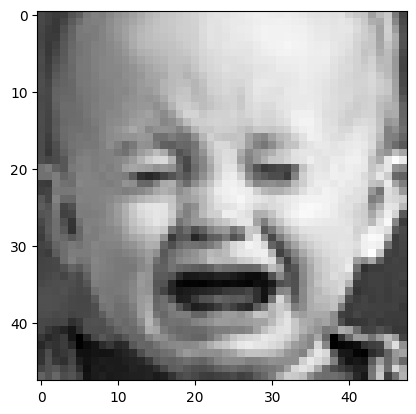

In [34]:
image = r"C:\Users\mehta\OneDrive\Desktop\Face_Emotion_Detection\archive\test\sad\PrivateTest_8886048.jpg"
print("original image is of sad")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of neutral
1/1 [==============================] - 0s 31ms/step
model prediction is  neutral


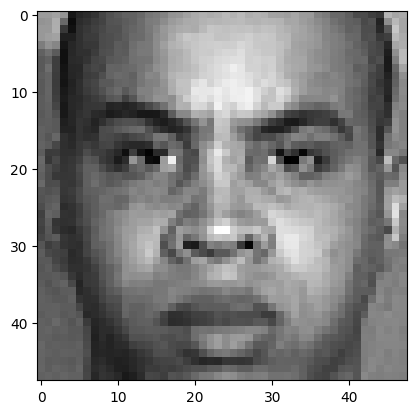

In [33]:
image = r"C:\Users\mehta\OneDrive\Desktop\Face_Emotion_Detection\archive\test\neutral\PrivateTest_49985410.jpg"
print("original image is of neutral")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of surprised
1/1 [==============================] - 0s 26ms/step
model prediction is  happy


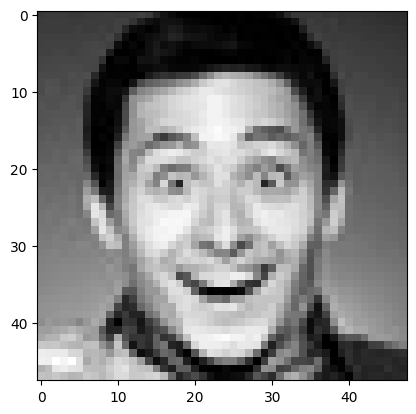

In [35]:
image = r"C:\Users\mehta\OneDrive\Desktop\Face_Emotion_Detection\archive\test\surprise\PrivateTest_10712253.jpg"
print("original image is of surprised")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

### Random test samples are checked with the original image and model prediction and fairly good results are obtained
#### Here first two images are classified correctly, but the last one is misclassified. Although the model classifies the surprised expression as happy, the similarity between the two expressions in this instance makes the misclassification understandable.






